In [1]:
import os
import pretty_midi
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import pygame

os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'


pygame 2.6.1 (SDL 2.28.4, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# load data
# path = "../../dataset/midi_dataset/filtered_midi_imgs_small.npy"
path = "../../dataset/quickdraw_dataset/eye_100.npy"
img_data = np.load(path, allow_pickle=True,)
print(f"Loaded {len(img_data)} midi files from {path}")
print(f"Shape of midi data: {img_data.shape}")



Loaded 43501 midi files from ../../dataset/quickdraw_dataset/eye_100.npy
Shape of midi data: (43501, 100, 100)


In [3]:
# make dataset 
import torch
from torch.utils.data import Dataset, DataLoader

picked_num = 43501
picked_img = img_data[:picked_num]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImgDataset(Dataset):
    def __init__(self, img_data):
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_file = self.img_data[idx]
        return img_file
# Create a dataset and dataloader
img_dataset = ImgDataset(picked_img)
img_dataloader = DataLoader(img_dataset, batch_size=256, shuffle=True)
# Check the shape of the data
for batch in img_dataloader:
    print(f"Batch shape: {batch.shape}")
    break
# Visualize the data
def visualize_img(img_file):
    img_file = img_file.reshape(100, 100)  # Reshape to 28x28 for visualization
    plt.imshow(img_file, cmap='gray')
    plt.axis('off')
    plt.show()

Batch shape: torch.Size([256, 100, 100])


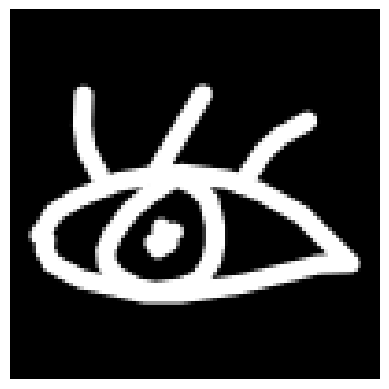

In [4]:
# Visualize a random img file
random_idx = random.randint(0, len(img_data) - 1)
img_file = img_data[random_idx]
visualize_img(img_file)


In [22]:
class ImgTokenDataset(Dataset):
    def __init__(self, raw_img_data, input_length, num_piles = 5):
        N, h, w = raw_img_data.shape
        assert(w%num_piles == 0), "The width of the image must be divisible by the number of piles"
        # raw_img_data = raw_img_data.reshape(N, h, w//num_piles, num_piles)
        self.raw_img_data = raw_img_data/255.0
        # Normalize the data to [0, 1]
        self.raw_img_data = np.clip(self.raw_img_data, 0.001, 0.999)
        # to float32
        self.raw_img_data = self.raw_img_data.astype(np.float32)
        # preprocess
        self.input_data = []
        self.output_data = []
        self.input_length = input_length
        for img_file in self.raw_img_data:
            img_file = img_file.reshape(h, w)
            # transpose
            img_file = np.transpose(img_file)
            img_file = img_file.reshape(w//num_piles, num_piles*h)
            for i in range(0, (w//num_piles) - input_length -1):
                if i>0 and i<(w//num_piles) - input_length -3:
                    if random.random() > 0.3:
                        continue
                input_data = img_file[i:i + input_length]
                # add some noise to the input data
                input_data = input_data + np.random.normal(0, 0.1, input_data.shape).astype(np.float32)
                output_data = img_file[i + input_length]
                self.input_data.append(input_data)
                self.output_data.append(output_data)
        self.input_data = np.array(self.input_data)
        self.output_data = np.array(self.output_data)

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_data = self.input_data[idx]
        output_data = self.output_data[idx]
        return input_data, output_data

input_length = 6
picked_num = 10000
num_piles = 5
picked_img = img_data[:picked_num]
img_token_dataset = ImgTokenDataset(picked_img, input_length, num_piles)
print(f"in total {len(img_token_dataset)} files ")
img_token_dataloader = DataLoader(img_token_dataset, batch_size=256, shuffle=True)

in total 60137 files 


Input data shape: (6, 500)
Output data shape: (500,)


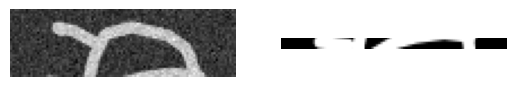

Input data shape: (6, 500)
Output data shape: (500,)


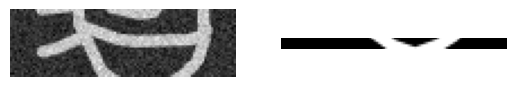

Input data shape: (6, 500)
Output data shape: (500,)


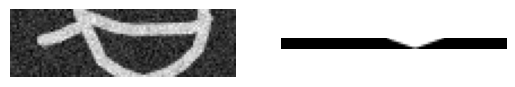

Input data shape: (6, 500)
Output data shape: (500,)


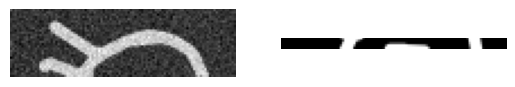

Input data shape: (6, 500)
Output data shape: (500,)


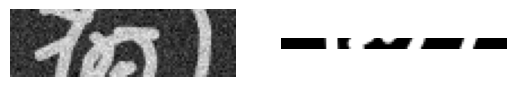

Input data shape: (6, 500)
Output data shape: (500,)


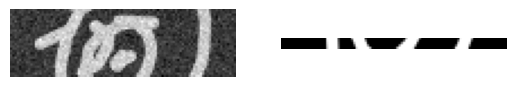

Input data shape: (6, 500)
Output data shape: (500,)


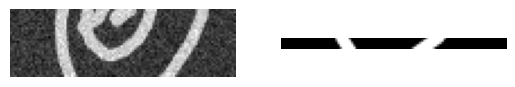

Input data shape: (6, 500)
Output data shape: (500,)


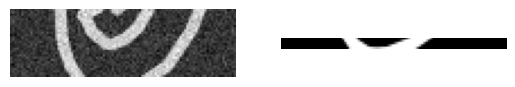

Input data shape: (6, 500)
Output data shape: (500,)


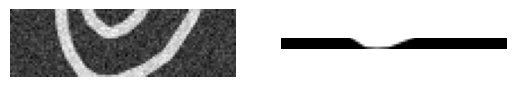

Input data shape: (6, 500)
Output data shape: (500,)


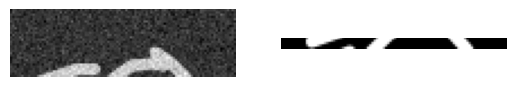

In [23]:
# visualize img_token_dataset
num_samples = 10
for i in range(num_samples):
    input_data, output_data = img_token_dataset[i]
    print(f"Input data shape: {input_data.shape}")
    print(f"Output data shape: {output_data.shape}")
    plt.subplot(1, 2, 1)
    plt.imshow(input_data.reshape(input_length*num_piles, 100), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(output_data.reshape(num_piles, 100), cmap='gray')
    plt.axis('off')
    plt.show()


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, time_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embedding = nn.Linear(patch_size, embed_dim*2)
        self.patch_embedding2 = nn.Linear(embed_dim*2, embed_dim)
        self.position_embedding = self._get_sine_cosine_embedding(time_size, embed_dim)
        self.relu = nn.ReLU()

    def _get_sine_cosine_embedding(self, seq_len, embed_dim):
        position_embedding = torch.zeros(seq_len, embed_dim)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        position_embedding[:, 0::2] = torch.sin(position * div_term)
        position_embedding[:, 1::2] = torch.cos(position * div_term)
        return position_embedding.unsqueeze(0)  # [1, seq_len, embed_dim]

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        x = self.relu(self.patch_embedding(x))  # [batch_size, seq_len, embed_dim*2]
        x = self.patch_embedding2(x)
        x += self.position_embedding[:, :seq_len, :].to(x.device)  # [1, seq_len, embed_dim]
        return x


class VisionLSTM(nn.Module):
    def __init__(self, input_dim, time_dim, embed_dim, hidden_dim, num_layers=1):
        super(VisionLSTM, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.embedding = PatchEmbedding(input_dim, time_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)  # Output to the original input dimension
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.view(x.size(0), x.size(1), -1)  # [batch_size, seq_len, input_dim]
        x = self.embedding(x)
        # print(f"Shape after embedding: {x.shape}")
        lstm_out, _ = self.lstm(x)
        # print(f"Shape after LSTM: {lstm_out.shape}")
        out = self.fc(lstm_out)
        out = self.sigmoid(out)
        return out

In [54]:
class VisionMLP(nn.Module):
    def __init__(self, input_dim, seq_length, embed_dim, hidden_dim, num_layers=1):
        super(VisionMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, embed_dim*2)
        self.fc12 = nn.Linear(embed_dim*2, embed_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(seq_length*embed_dim, hidden_dim*2)
        self.fc22 = nn.Linear(hidden_dim*2, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)  # Output to the original input dimension
        self.fc32 = nn.Linear(input_dim, input_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))  # [batch_size, seq_len, embed_dim]
        x = self.fc12(x)
        x = x.flatten(start_dim=1)  # [batch_size, seq_len*embed_dim]
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc22(x))
        x = self.relu(self.fc3(x))
        x = self.fc32(x)
        x = self.sigmoid(x)
        return x

In [58]:
import torch.optim as optim
# model = VisionLSTM(input_dim = 100*num_piles, time_dim = 100//num_piles, embed_dim=32, hidden_dim=256, num_layers=1)
model = VisionMLP(input_dim = 100*num_piles, seq_length = input_length, embed_dim=16, hidden_dim=256, num_layers=1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


def train(model, dataloader, optimizer, criterion, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for i, batch in enumerate(img_token_dataloader):
            # print("traning batch ", i, "out of ", len(img_token_dataloader))
            input_tokens, target_tokens = batch
            input_tokens = input_tokens.to(device)
            target_tokens = target_tokens.to(device)
            # print("min in input_tokens: ", input_tokens.min())
            # print("max in input_tokens: ", input_tokens.max())
            optimizer.zero_grad()
            output = model(input_tokens)
            # output = output[:,-1,:]
            # print("output shape: ", output.shape)
            # print("target_tokens shape: ", target_tokens.shape)
            loss = criterion(output, target_tokens)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(img_token_dataloader)}")

In [61]:
train(model, img_token_dataloader, optimizer, criterion, device, num_epochs=100)

Epoch 1/100, Loss: 565.5403674835854
Epoch 2/100, Loss: 565.5014945821559
Epoch 3/100, Loss: 565.4852162462599
Epoch 4/100, Loss: 565.4613083859707
Epoch 5/100, Loss: 565.438022305103
Epoch 6/100, Loss: 565.4131952813331
Epoch 7/100, Loss: 565.3925061814329
Epoch 8/100, Loss: 565.3899701057596
Epoch 9/100, Loss: 565.3598619826297
Epoch 10/100, Loss: 565.342502934882
Epoch 11/100, Loss: 565.3270063684341
Epoch 12/100, Loss: 565.3156172082779
Epoch 13/100, Loss: 565.2538317091921
Epoch 14/100, Loss: 565.263690834857
Epoch 15/100, Loss: 565.2450509578624
Epoch 16/100, Loss: 565.2401278881316
Epoch 17/100, Loss: 565.201701452377
Epoch 18/100, Loss: 565.1573200631649
Epoch 19/100, Loss: 565.1783099235372
Epoch 20/100, Loss: 565.1749257189163
Epoch 21/100, Loss: 565.1797172384059
Epoch 22/100, Loss: 565.1367634225398
Epoch 23/100, Loss: 565.1502632303441
Epoch 24/100, Loss: 565.108773998504
Epoch 25/100, Loss: 565.0988812385722
Epoch 26/100, Loss: 565.0835950486204
Epoch 27/100, Loss: 565.06

full_picture shape:  (1, 56, 500)


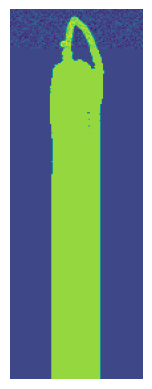

full_picture shape:  (1, 56, 500)


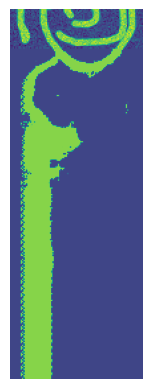

full_picture shape:  (1, 56, 500)


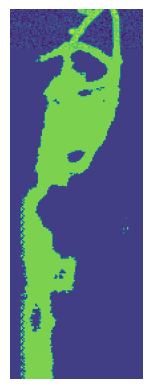

full_picture shape:  (1, 56, 500)


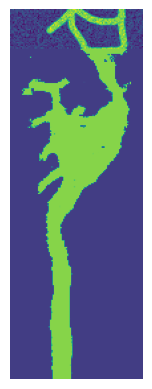

full_picture shape:  (1, 56, 500)


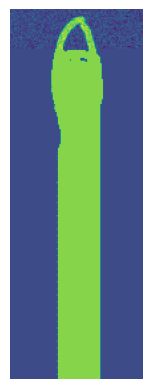

full_picture shape:  (1, 56, 500)


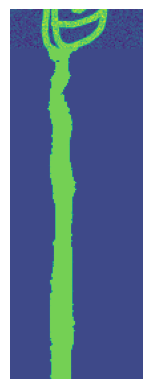

full_picture shape:  (1, 56, 500)


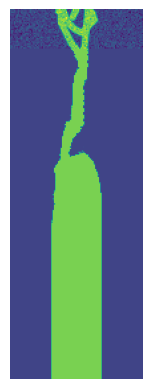

full_picture shape:  (1, 56, 500)


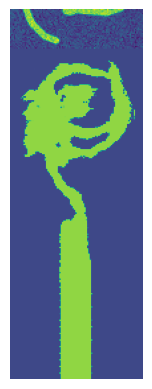

full_picture shape:  (1, 56, 500)


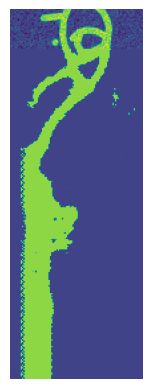

full_picture shape:  (1, 56, 500)


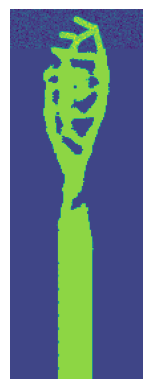

In [68]:
# visualize some results
def visualize_results(model, dataloader, num_samples=5, num_predict = 50):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
            input_tokens, target_tokens = batch
            input_tokens = input_tokens[0].unsqueeze(0)
            input_tokens = input_tokens.to(device)
            full_picture = input_tokens.cpu().numpy() # [1, 10, 100]
            for j in range(num_predict):
                output = model(input_tokens).unsqueeze(0)
                # output = output[:,-1,:].unsqueeze(0)
                input_tokens = torch.cat((input_tokens, output), dim=1)
                input_tokens = input_tokens[:, 1:, :]
                full_picture = np.concatenate((full_picture, output.cpu().numpy()), axis=1)
            print("full_picture shape: ", full_picture.shape)
            full_picture = full_picture[0]
            h, w = full_picture.shape
            full_picture = full_picture.reshape(h*num_piles, w//num_piles)
            plt.imshow(full_picture)
            plt.axis('off')
            plt.show()
            
visualize_results(model, img_token_dataloader, num_samples=10, num_predict=50)